In [5]:
import pandas as pd

train_file = u'preliminary_contest_data/train.csv'
train = pd.read_csv(train_file)

train.describe()
train.head(3)

,aid,uid,label
0,699,78508957,-1
1,1991,3637295,-1
2,1119,19229018,-1


In [4]:
test_file = u'preliminary_contest_data/test1.csv'
test = pd.read_csv(test_file)

test.describe()
test.head(3)

,aid,uid
0,2118,64355836
1,692,45051997
2,692,10869198


In [6]:
ad_feature = pd.read_csv(u'preliminary_contest_data/adFeature.csv')
ad_feature.head(3)

,aid,advertiserId,campaignId,creativeId,creativeSize,adCategoryId,productId,productType
0,177,8203,76104,1500666,59,282,0,6
1,2050,19441,178687,245165,53,1,0,6
2,1716,5552,158101,1080850,35,27,113,9


In [3]:
import pandas as pd
import lightgbm as lgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from scipy import sparse
import os
import gc
import math
import numpy as np



def get_user_feature():

    user_feature=pd.read_csv('./data/userFeature1.csv')
    return user_feature

def get_data():
    if os.path.exists('./data/data.csv'):
        return pd.read_csv('./data/data.csv')
    else:
        ad_feature = pd.read_csv('./data/adFeature.csv')
        train=pd.read_csv('./data/train.csv')
        predict=pd.read_csv('./data/test1.csv')
        train.loc[train['label']==-1,'label']=0
        predict['label']=-1
        user_feature=get_user_feature()
        data=pd.concat([train,predict])
        data=pd.merge(data,ad_feature,on='aid',how='left')
        data=pd.merge(data,user_feature,on='uid',how='left')
        data=data.fillna('-1')
        del user_feature
        return data

def batch_predict(data,index):
    one_hot_feature=['LBS','age','carrier','consumptionAbility','education','gender','house','os','ct','marriageStatus','advertiserId','campaignId', 'creativeId',
           'adCategoryId', 'productId', 'productType']
    vector_feature=['appIdAction','appIdInstall','interest1','interest2','interest3','interest4','interest5','kw1','kw2','kw3','topic1','topic2','topic3']
    for feature in one_hot_feature:
        try:
            data[feature] = LabelEncoder().fit_transform(data[feature].apply(int))
        except:
            data[feature] = LabelEncoder().fit_transform(data[feature])

    train=data[data.label!=-1]
    train_y=train.pop('label')
    test=data[data.label==-1]
    res=test[['aid','uid']]
    test=test.drop('label',axis=1)
    enc = OneHotEncoder()
    train_x=train[['creativeSize']]
    test_x=test[['creativeSize']]

    for feature in one_hot_feature:
        enc.fit(data[feature].values.reshape(-1, 1))
        train_a=enc.transform(train[feature].values.reshape(-1, 1))
        test_a = enc.transform(test[feature].values.reshape(-1, 1))
        train_x= sparse.hstack((train_x, train_a))
        test_x = sparse.hstack((test_x, test_a))
        print(feature+' finish')
    print('one-hot prepared !')

    cv=CountVectorizer()
    for feature in vector_feature:
        cv.fit(data[feature])
        train_a = cv.transform(train[feature])
        test_a = cv.transform(test[feature])
        train_x = sparse.hstack((train_x, train_a))
        test_x = sparse.hstack((test_x, test_a))
        print(feature + ' finish')
    print('cv prepared !')
    del data
    return LGB_predict(train_x, train_y, test_x, res,index)

def LGB_predict(train_x,train_y,test_x,res,index):
    print("LGB test")
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
        max_depth=-1, n_estimators=1500, objective='binary',
        subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
        learning_rate=0.05, min_child_weight=50, random_state=2018, n_jobs=-1
    )
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y)], eval_metric='auc',early_stopping_rounds=100)
    res['score'+str(index)] = clf.predict_proba(test_x)[:,1]
    res['score'+str(index)] = res['score'+str(index)].apply(lambda x: float('%.6f' % x))
    print(str(index)+' predict finish!')
    gc.collect()
    res=res.reset_index(drop=True)
    return res['score'+str(index)]

In [5]:
user_feature = get_user_feature()
user_feature.describe()

,LBS,age,carrier,consumptionAbility,education,gender,house,uid
count,1.999987e+06,2.000001e+06,2.000001e+06,2.000001e+06,2.000001e+06,2.000001e+06,367011.0,2.000001e+06
mean,4.449164e+02,3.018002e+00,1.098605e+00,9.591575e-01,4.532909e+00,1.313138e+00,1.0,4.127246e+07
std,2.848777e+02,1.518821e+00,9.623770e-01,6.342369e-01,2.441015e+00,4.704271e-01,0.0,2.382967e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,2.100000e+01
25%,1.920000e+02,2.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.0,2.063093e+07
50%,4.250000e+02,3.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,1.0,4.126735e+07
75%,6.870000e+02,4.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00,2.000000e+00,1.0,6.192053e+07
max,9.970000e+02,5.000000e+00,3.000000e+00,2.000000e+00,7.000000e+00,2.000000e+00,1.0,8.254288e+07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe584f5c748>,
      dtype=object)

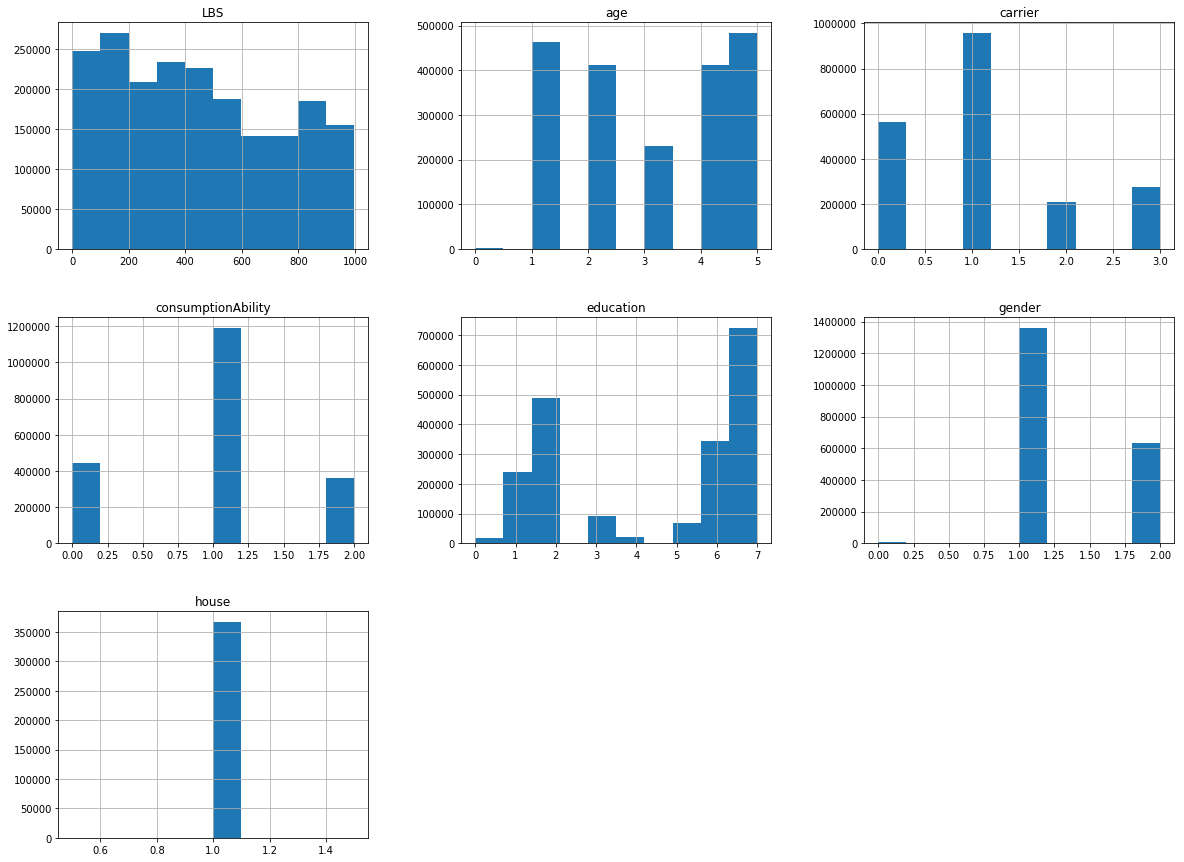

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline
col_plt = ['LBS', 'age', 'carrier', 'consumptionAbility', 'education', 'gender', 'house']

user_feature[col_plt].hist(bins=10, figsize=(20,15))

In [26]:
col_lst = ['LBS', 'age', 'appIdAction', 'appIdInstall', 'carrier',
       'consumptionAbility', 'ct', 'education', 'gender', 'house', 'interest1',
       'interest2', 'interest3', 'interest4', 'interest5', 'kw1', 'kw2', 'kw3',
       'marriageStatus', 'os', 'topic1', 'topic2', 'topic3', 'uid']


user_feature.describe()

,LBS,age,carrier,consumptionAbility,education,gender,house,uid
count,1.999987e+06,2.000001e+06,2.000001e+06,2.000001e+06,2.000001e+06,2.000001e+06,367011.0,2.000001e+06
mean,4.449164e+02,3.018002e+00,1.098605e+00,9.591575e-01,4.532909e+00,1.313138e+00,1.0,4.127246e+07
std,2.848777e+02,1.518821e+00,9.623770e-01,6.342369e-01,2.441015e+00,4.704271e-01,0.0,2.382967e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,2.100000e+01
25%,1.920000e+02,2.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.0,2.063093e+07
50%,4.250000e+02,3.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,1.0,4.126735e+07
75%,6.870000e+02,4.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00,2.000000e+00,1.0,6.192053e+07
max,9.970000e+02,5.000000e+00,3.000000e+00,2.000000e+00,7.000000e+00,2.000000e+00,1.0,8.254288e+07


In [6]:
col_lst2 = ['appIdAction', 'appIdInstall','ct','interest1','interest2', 'interest3', 'interest4', 'interest5', 'kw1', 'kw2', 'kw3','marriageStatus', 'os', 'topic1', 'topic2', 'topic3']

user_feature[col_lst2].describe()

,appIdAction,appIdInstall,ct,interest1,interest2,interest3,interest4,interest5,kw1,kw2,kw3,marriageStatus,os,topic1,topic2,topic3
count,29902,40355,2000001,1830353,1299416,52373,29926,1492210,1811996,1926920,91240,2000001,2000001,1840913,1922917,91466
unique,26045,39335,65,1231855,345163,284,254,1341228,1770828,1644534,74712,22,5,1816098,1222240,86185
top,4581,38923,3 1,36 11,24 30,6 8 10 4 9 1 7 3 5 2,4 5,100 46,8561,9088 56438 47308 40921 30993,36983 45477 22819 30214 43606,10,1,6424 7477 1635 1747,4739 5791 6457 9917 9953,2864 551 292 6545 8117
freq,237,80,567759,52146,86886,18618,2932,3051,2074,4000,133,747511,1177026,385,4633,213


In [2]:
import pandas as pd

data = pd.read_csv('./data/userFeatureCompressed.csv')
data.describe()

,gender
count,1.142004e+07
mean,1.313553e+00
std,4.706072e-01
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.000000e+00
